# Поиск аномалий

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque #очередь (первым пришел, последним вышел)
import pandas as pd

In [5]:
data = pd.read_csv('data/international-airline-passengers.csv')
data['Count'].head()

0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64

In [6]:
#исказим сигнал, добавим аномалию
data.at[100, 'Count'] = 0
data.loc[90, 'Count'] = 50
data.loc[40, 'Count'] = 400
serias_1=data['Count']

In [116]:
serias_1.head()

0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64

## Пример сигнала

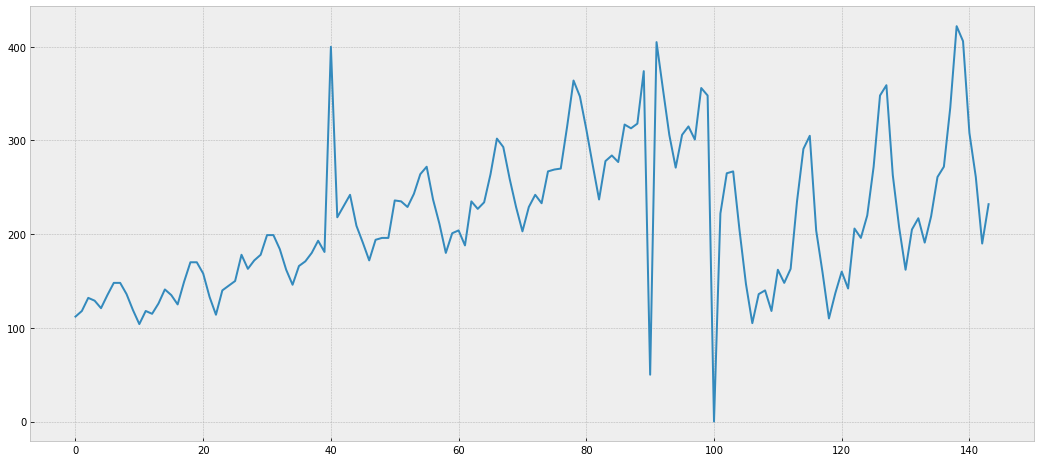

In [296]:
with plt.style.context('bmh'):
    plt.figure(figsize=(18, 8))
    plt.plot(serias_1)


В этом сигнале есть несколько точек изменения. Мы хотим иметь возможность обнаруживать эти типы изменений и различать важные изменения и незначительные изменения.

  * Мы можем решить, что незначительные колебания или шум сигнала не важны и должны быть проигнорированы нашим алгоритмом обнаружения изменений.
  * А как насчет незначительных изменений в точках 40,90,100? Это важно?

In [283]:
data.loc[101:,'Count'] -= 200
serias_2=data['Count']

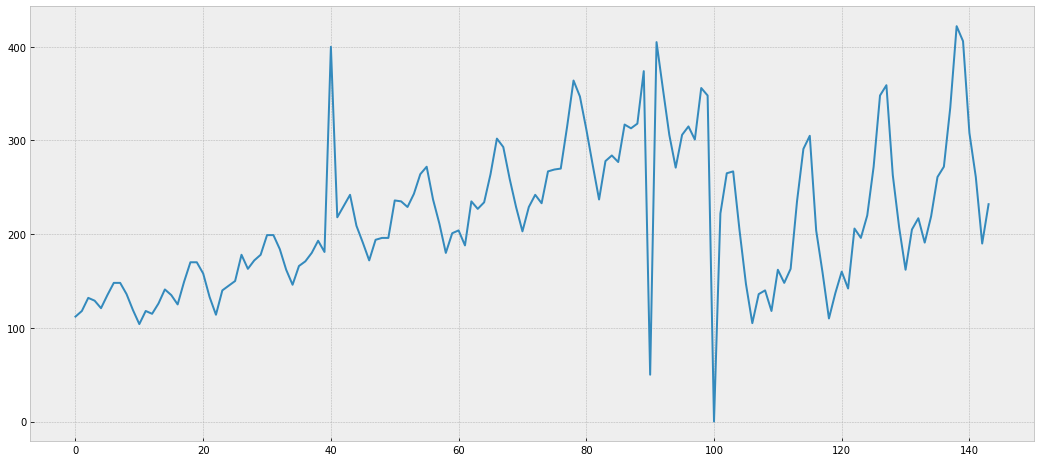

In [297]:
with plt.style.context('bmh'):
    plt.figure(figsize=(18, 8))
    plt.plot(serias_2)


У нас нет информации о будущем поведении сигнала. Поэтому, когда мы сталкиваемся с изменением в точке 100, мы должны решить, важно это или нет БЕЗ ЗНАНИЯ о более крупном падении в 101.

  * Резкое падение в точке 101 - это изменение с наибольшей величиной в нашем сигнале. Но почему это так? Что-то важное происходит? или точка отсутствует в выборке и интерпретируется как «0»?

### Сигнал с периодичными аномалиями

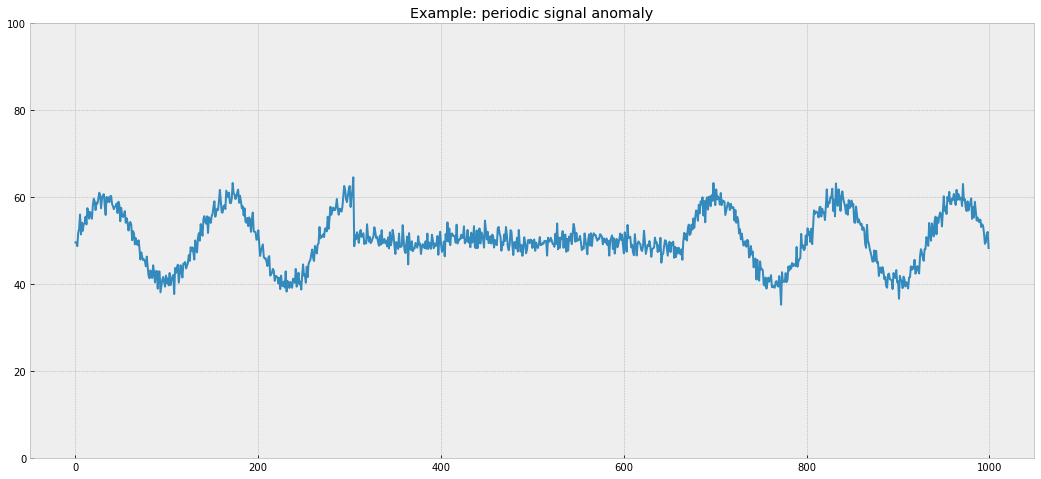

In [298]:
signal = np.sin(np.linspace(0, 15*np.pi, num=1000))
signal[305:655] *= 0.1
signal = 10 * signal + 50

noise = np.random.normal(scale = 1.5, size=1000)
signal = signal + noise

with plt.style.context('bmh'):
    plt.figure(figsize=(18, 8))
    plt.ylim(0,100)
    plt.plot(signal)
    plt.title('Example: periodic signal anomaly')
    plt.show()

# Поиск аномалий

## 1. Мат ожидание

Идея: Сравниваем на сколько сильно от среднего идет отклонение по нашим данным

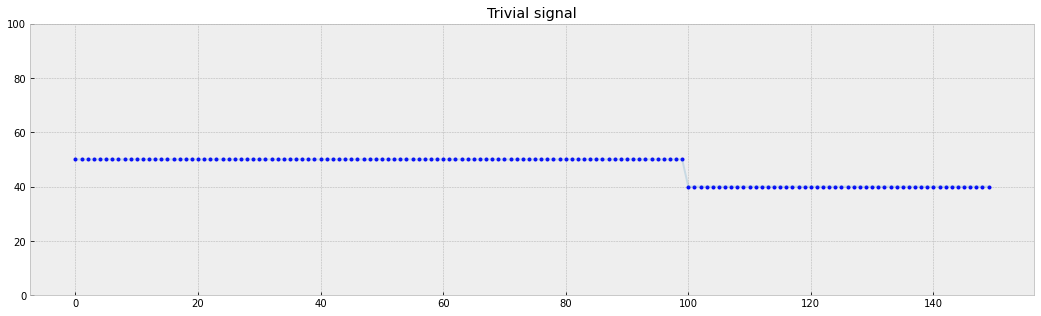

In [10]:
sig1 = np.ones(150)
sig1[:100] *= 50
sig1[100:] *= 40

with plt.style.context('bmh'):
    plt.figure(figsize=(18, 5))
    plt.plot(sig1, 'b.')
    plt.plot(sig1, '-', alpha=0.2)
    plt.ylim(0,100)
    plt.title("Trivial signal")
    plt.show()

Давайте рассмотрим простой детектор:
* Расчитываем среднее значение в каждой точке
* Сигнализируем об изменении, если значение сигнала превосходит мат ожидание на какой-то порог

In [17]:
class MeanDetector:
    #threshold погрешность
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    #обновление значений котроые есть (берем новый сигнал) Считаем среднее для каждой точки
    def update(self, new_signal_value):
        self.count += 1#увеличиваем счетчик сигнала
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    #сравнение
    def check(self, new_signal_value): 
        #умножаем среднее в текущей точке на погрешность
        threshold_level = self.mean * self.threshold
        #сравниваем новое значение сигнала-среднее с уровнем сигнала
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True#если привысили порог, то обнаружили аномалию
        return False

In [7]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(18, 5))
        plt.plot(signal, 'b.')
        plt.plot(signal, 'b-', alpha=0.15)
        plt.title('Signal')

        if stop_points:
            plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                          colors='r', linestyles='dotted')

        plt.show()

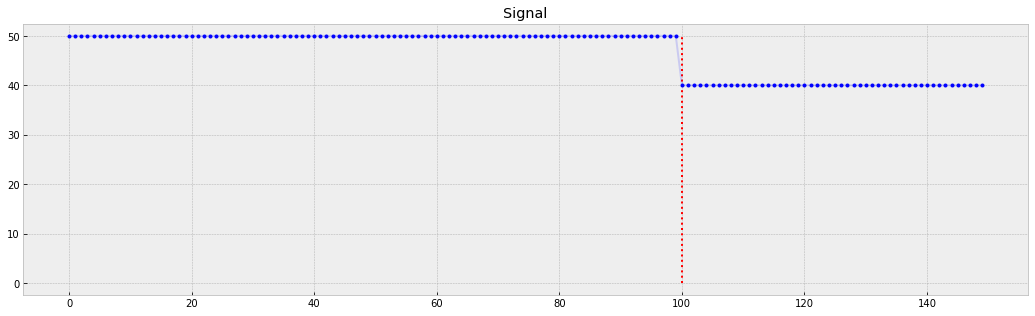

In [134]:
simulate(MeanDetector(), sig1)

### Масштабирование

Применим детектор к отмасштабированному в 1000 раз сигналу

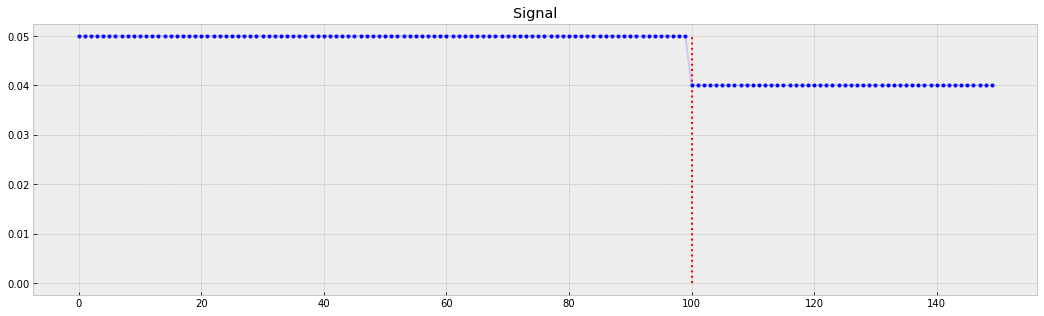

In [135]:
simulate(MeanDetector(), sig1 / 1000)

### Зашумление

Сигнал + гауссовий шум с размахом 0.02, 0.1, 0.2 от высоты перепада

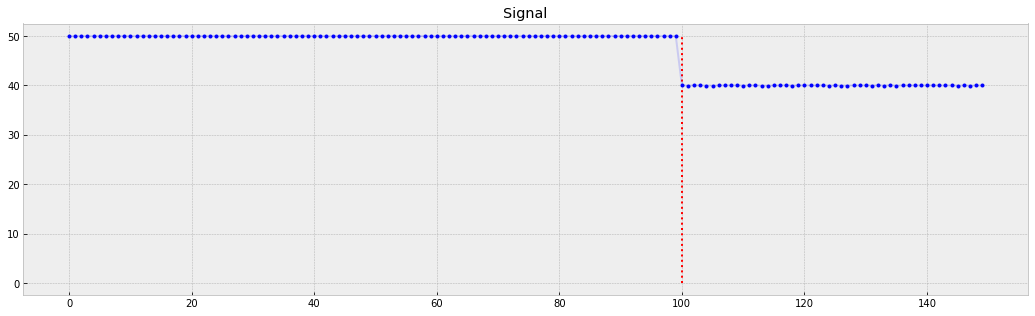

In [137]:
simulate(MeanDetector(), sig1 + np.random.normal(scale = 0.02, size=len(sig1)))

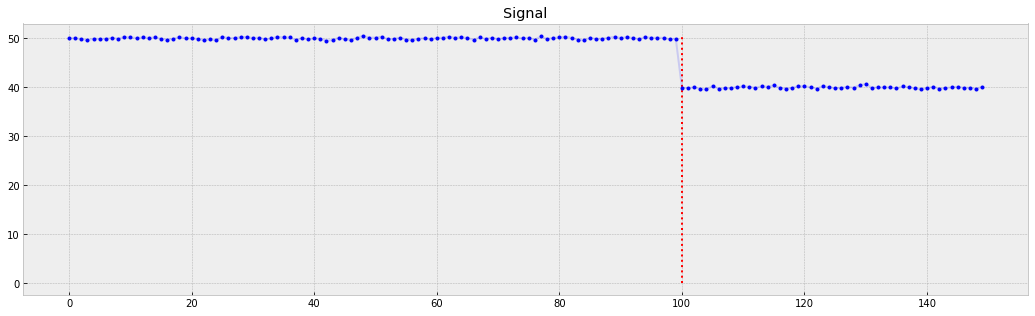

In [138]:
simulate(MeanDetector(), sig1 + np.random.normal(scale = 0.2, size=len(sig1)))

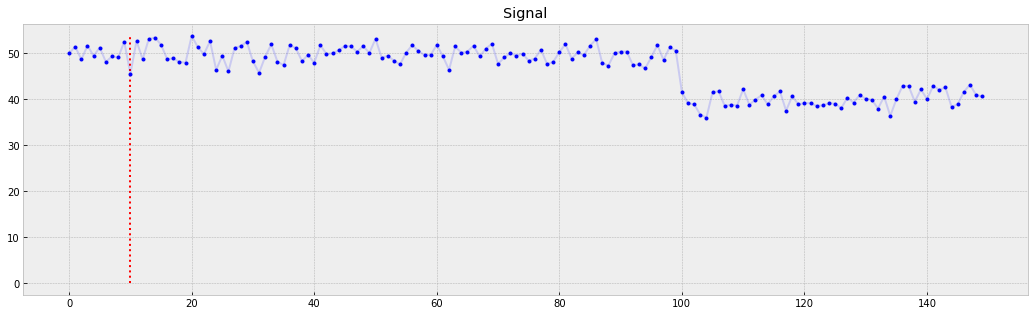

In [139]:
simulate(MeanDetector(), sig1 + np.random.normal(scale = 2, size=len(sig1)))

### Еще недостатки

  * Чувствительность к пороговому значению, которое мы определяем вручную.
  * Чувствительность к аномальным значениям и выбросам
  * Сигнал должен быть постоянным. детектор плохо работает с трендом или локальным изменением (сезонность)

Ручная настройка и эвристика могут решить некоторые из этих проблем, но зачастую его конечно не хватает

## Сигнал с сезонностью

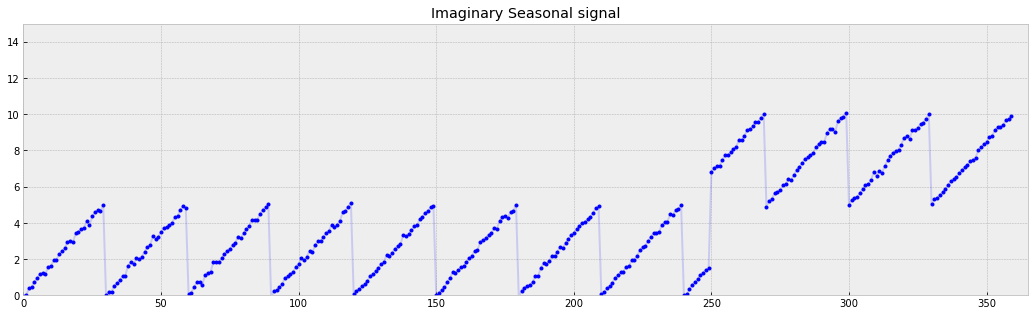

In [19]:
sig2 = np.linspace(0, 5, num=30)
sig2 = np.concatenate([sig2 for x in range(12)])

jump_size = 5
sig2[250:] = sig2[250:] + jump_size

# Noise
noise = np.random.normal(
    size=sig2.shape,
    scale=jump_size * 0.02)

with plt.style.context('bmh'):
    plt.figure(figsize=(18, 5))
    plt.plot(sig2 + noise, 'b.', linestyle='')
    plt.plot(sig2 + noise, 'b-', alpha=0.15)
    plt.ylim(0,15)
    plt.xlim(0,365)
    plt.title("Imaginary Seasonal signal")
    plt.show()

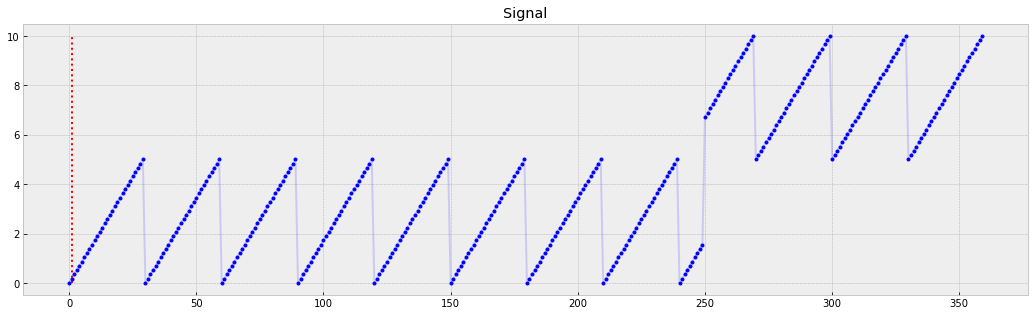

In [18]:
simulate(MeanDetector(), sig2)

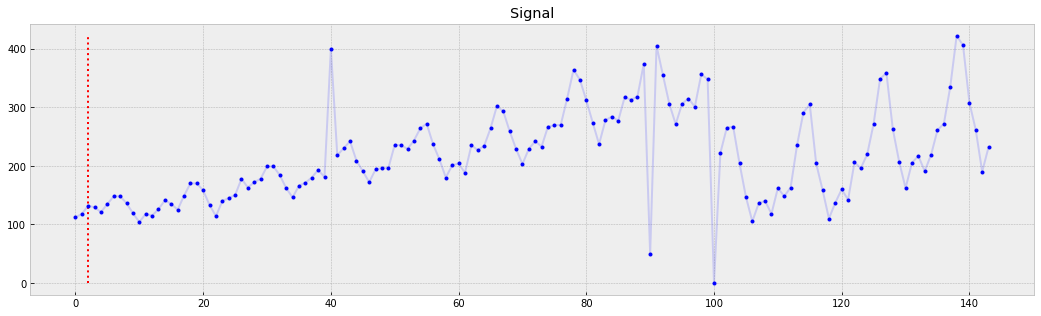

In [286]:
simulate(MeanDetector(), serias_2)

## 2. Потоковые окна

Потоковые окна - это подход к обнаружению изменений, где мы сохраняем статистику (например, среднее значение) на двух отдельных образцах (или окнах) сигнала.

Обычно для одного из окон мы используем только последние $n$ точки данных. Для другого окна мы можем использовать гораздо большее окно или весь сигнал, который мы видели с момента $t = 0$.

Затем мы можем сравнить то, что происходило «недавно» с тем, как сигнал вел себя раньше.

### Остерегайтесь практических ограничений
Зачастую нельзя хранить все данные - нужны "умные" алгоритмы для хранения статистик по точкам.

#### Метод Велфорда
Будем использовать метод Welford для вычисления среднего значения и дисперсии. 

## zscore

### Zscore (определение)
При сравнении двух гауссовских моделей z-оценка - это расстояние от среднего значения выборки до среднего значения совокупности в единицах стандартной ошибки. Он часто используется для определения того, отличается ли выборка точек данных от исследуемой совокупности.

$$z_{score} = \frac{(M - \sigma)}{SE}$$

 * Совокупность имеет среднее значение $\mu$ и стандартное отклонение $\sigma$.
 * Выборка имеет среднее значение $M$ и размер $n$.
 * SE - это стандартная ошибка:
$$SE = \frac{\sigma}{\sqrt{n}}$$
    

### Использование Zscore

Для нашего следующего детектора точек изменений мы будем поддерживать два набора статистических данных о нашем сигнале и сравнивать их с помощью z-score. Ссылаясь на приведенные выше формулы, нам нужно вычислить среднее и стандартное отклонение для каждого набора.

Мы будем использовать весь сигнал, который мы видели до сих пор, для вычисления статистик совокупности.
Мы будем использовать движущееся окно из последних $n$ точек для вычисления статистик выборки.

In [11]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  #сколько всего значений
        self.g_mean = 0.0  # среднее значение на всей последовательности 
        self.s = 0.0  # метод Welford's. Дисперсия = s / (k + 1)
        self.window = deque(maxlen = window_size)#окно (первое значение приходит - последнее вылетает)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value#новое значение сигнала
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean#старое значение глобального среднего
        newm = oldm + (x - oldm) / (self.k + 1)#новое значение среднего
        s = self.s + (x - newm) * (x - oldm)#обновляется дисперсия s = (x-M)^2)
        g_mean = newm#обновляется глобальное среднее
        g_std = np.sqrt(s / (self.k+1))#глобальное среднее квадратичное отклонение (SE)  метод Welford's. Дисперсия = s / (k + 1)      
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        #std_diff = (g_std - w_std) / g_std  
        SE = g_std / np.sqrt(self.window_size)
        #mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE#Z=(M-q)/SE       
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True#изменения произошли
        return False

<ipython-input-11-f332b46e5d21>:31: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE#Z=(M-q)/SE


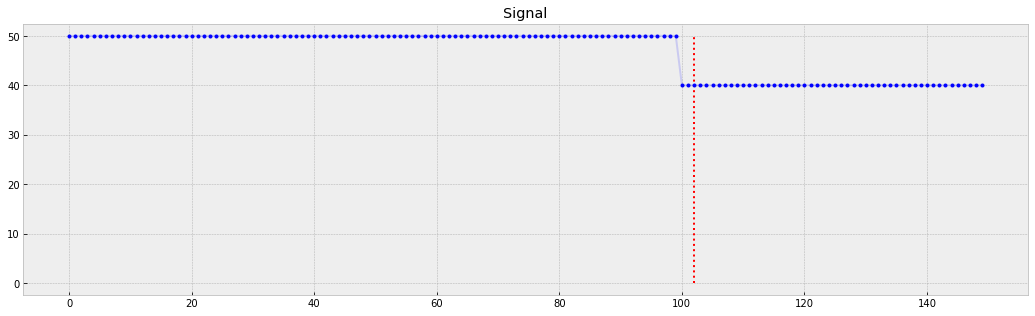

In [12]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig1)

Изменеение было заметно не сразу. «Изменение произошло где-то в нашем локальном окне». Чем больше окно, тем меньше вероятность того, что мы находимся именно там, где произошли изменения.

### Торг в обнаружении изменений
Компромисс между задержкой обнаружения и частотой ложных срабатываний.

### Сезонность

<ipython-input-11-f332b46e5d21>:31: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE#Z=(M-q)/SE


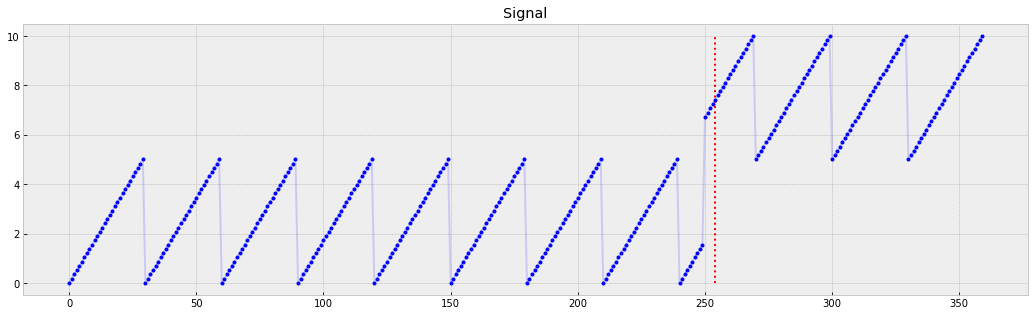

In [20]:
simulate(ZScoreDetector(window_size=5, threshold=5.0), sig2)

## Выбросы

<Figure size 1296x360 with 0 Axes>

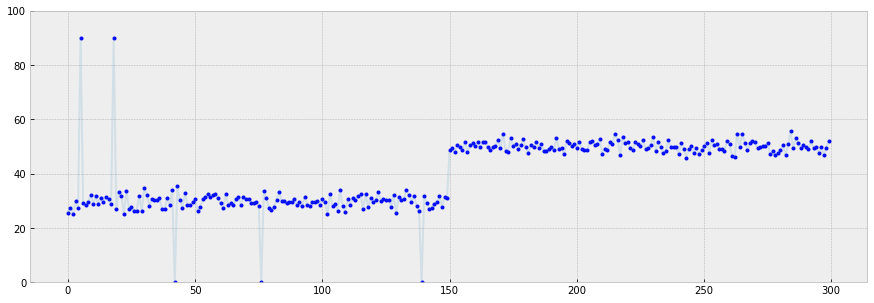

In [150]:
jump_size = 20
signal_size = 300

sig3 = np.ones(signal_size)
sig3[:150] = 30
sig3[150:] = 30 + jump_size

noise = np.random.normal(
    scale = 0.10 * jump_size,
    size=signal_size)

sig3 = sig3 + noise

outlier_idx = np.random.choice(signal_size, size=3)
sig3[outlier_idx] = 0
outlier_idx = np.random.choice(signal_size, size=2)
sig3[outlier_idx] = 90
with plt.style.context('bmh'):
    plt.figure(figsize=(18, 5))
    plt.figure(figsize=(15, 5))
    plt.plot(sig3, 'b.')
    plt.plot(sig3, '-', alpha=0.15)
    plt.ylim(0,100)
    plt.show()

<ipython-input-144-b989426caa02>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-144-b989426caa02>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


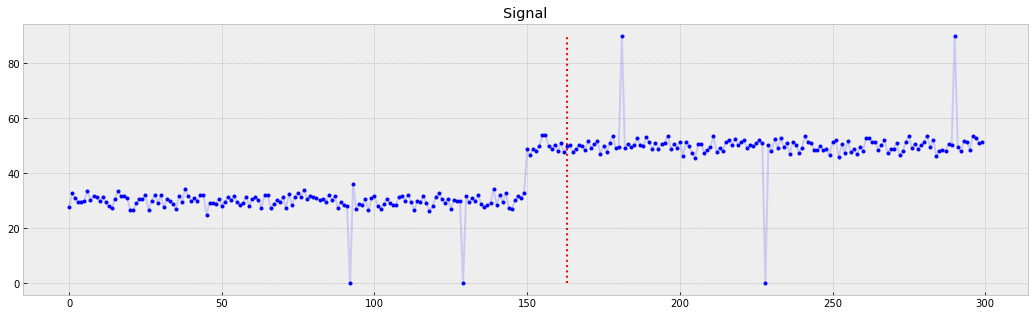

In [148]:
simulate(ZScoreDetector(window_size=20, threshold=8.0), sig3)

<Figure size 1296x360 with 0 Axes>

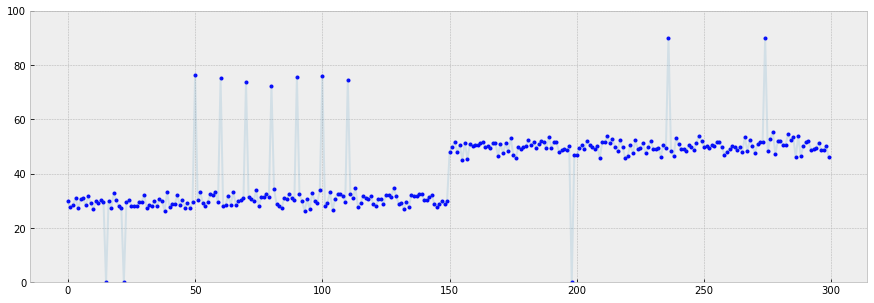

In [151]:
jump_size = 20
signal_size = 300

sig4 = np.ones(signal_size)
sig4[:150] = 30
sig4[150:] = 30 + jump_size

for ind in range(50, 120, 10):
    sig4[ind] = 75

noise = np.random.normal(
    scale = 0.10 * jump_size,
    size=signal_size)

sig4 = sig4 + noise

outlier_idx = np.random.choice(signal_size, size=3)
sig4[outlier_idx] = 0
outlier_idx = np.random.choice(signal_size, size=2)
sig4[outlier_idx] = 90

with plt.style.context('bmh'):
    plt.figure(figsize=(18, 5))
    plt.figure(figsize=(15, 5))
    plt.plot(sig4, 'b.')
    plt.plot(sig4, '-', alpha=0.15)
    plt.ylim(0,100)
    plt.show()

<ipython-input-144-b989426caa02>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-144-b989426caa02>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


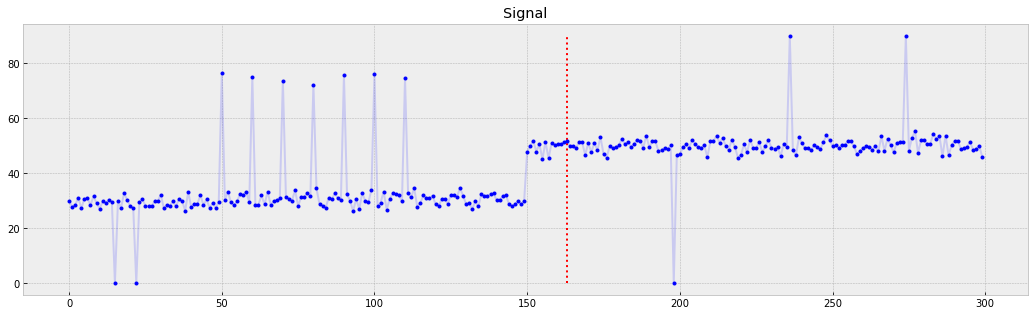

In [152]:
simulate(ZScoreDetector(window_size=20, threshold=4.0), sig4)

<ipython-input-144-b989426caa02>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-144-b989426caa02>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


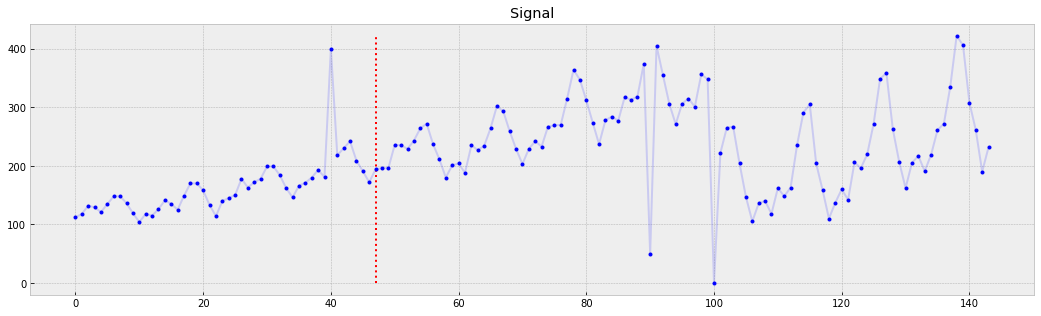

In [293]:
simulate(ZScoreDetector(window_size=10, threshold=4.0), serias_2)

### 3. Кумулятивные суммы

Алгоритм [Кумулятивная сумма (CUSUM)](http://en.wikipedia.org/wiki/CUSUM) является классическим методом мониторинга обнаружения изменений. Одной из форм реализации алгоритма CUSUM является вычисление суммарной суммы положительных и отрицательных изменений ($g_t^+$ и $g_t^-$) в данных и сравнение результата с некоторым порогом. Когда этот порог превышен - обнаружено изменение. Чтобы избежать обнаружения изменения (например, при наличии тренда) - в алгоритм добавляют параметр для его учета ($drift$):

$$ \begin{array}{l l} 
\left\{ \begin{array}{l l} 
s[t] = x[t] - x[t-1] \\
g^+[t] = max\left(g^+[t-1] + s[t]-drift,\; 0\right) \\
g^-[t] = max\left(g^-[t-1] - s[t]-drift,\; 0\right)
\end{array} \right. \\
\\
\; if \;\;\; g^+[t] > threshold \;\;\; or \;\;\;  g^-[t] > threshold: \\
\\
\left\{ \begin{array}{l l} 
t_{talarm}=t \\
g^+[t] = 0 \\
g^-[t] = 0 
\end{array} \right.
\end{array} $$

In [299]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            with plt.style.context('bmh'):
                _, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

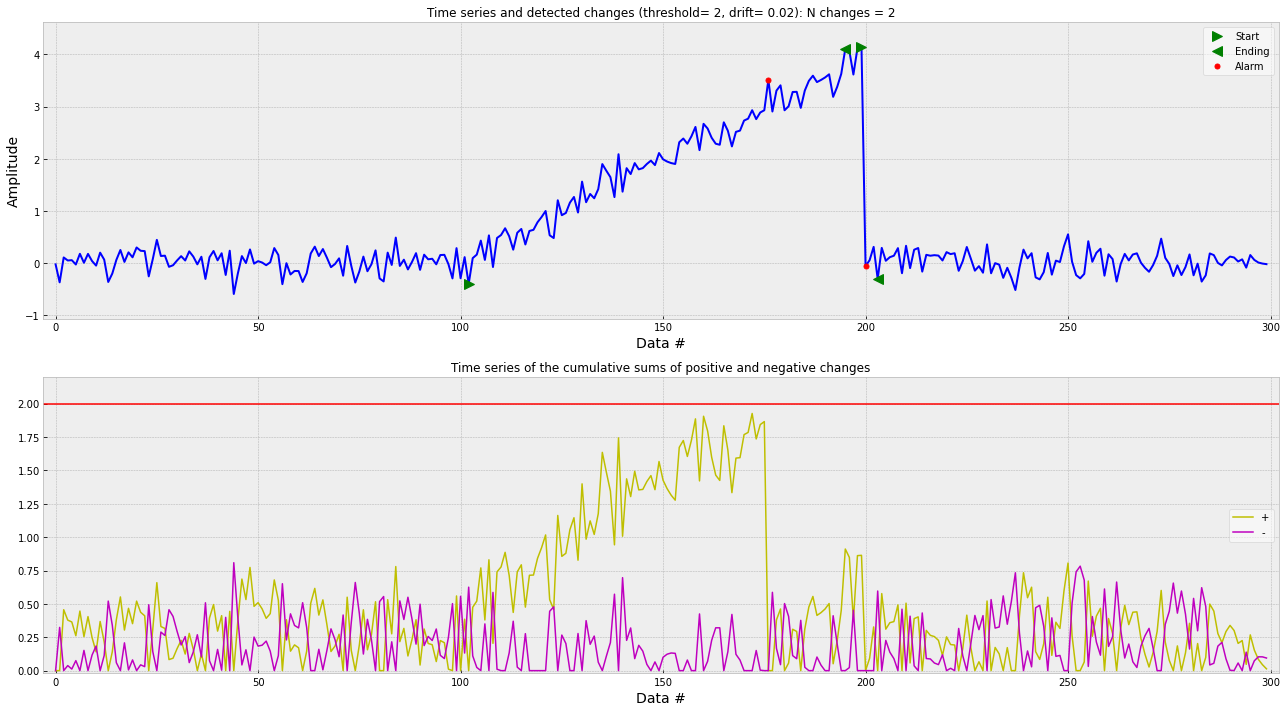

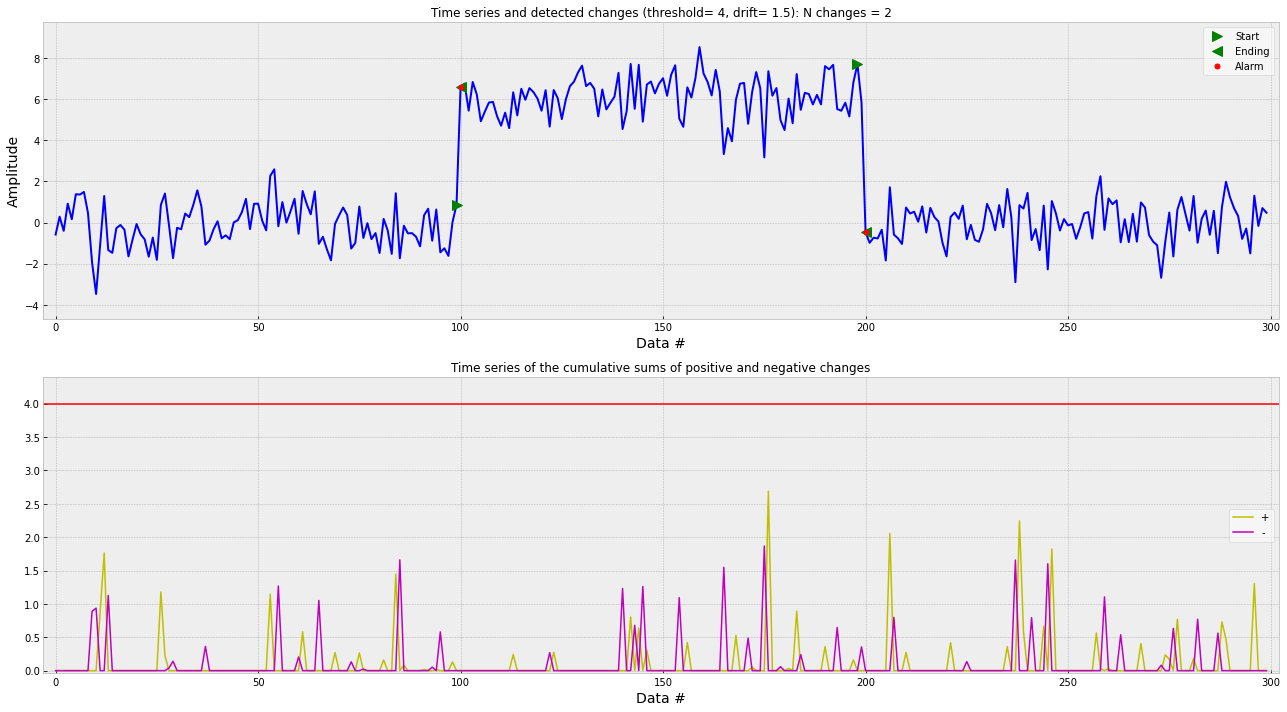

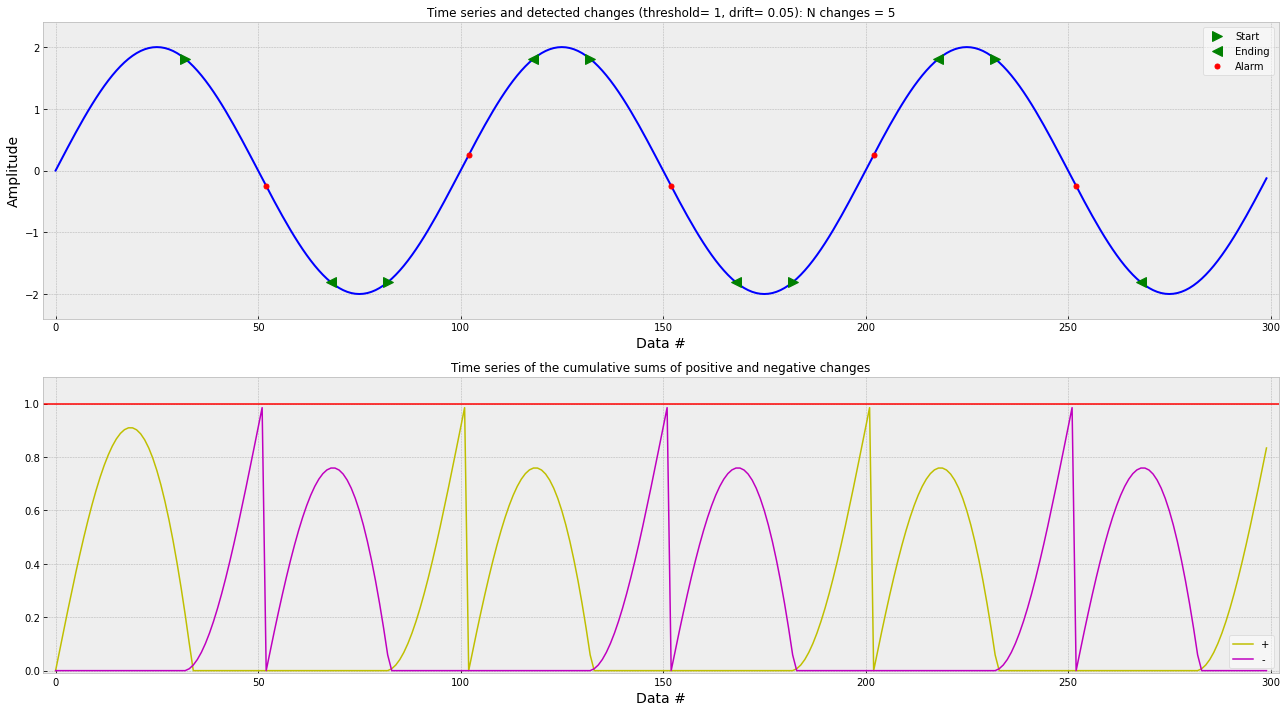

In [159]:
x = np.random.randn(300)/5
x[100:200] += np.arange(0, 4, 4/100)
ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

x = np.random.randn(300)
x[100:200] += 6
detect_cusum(x, 4, 1.5, True, True)
    
x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)

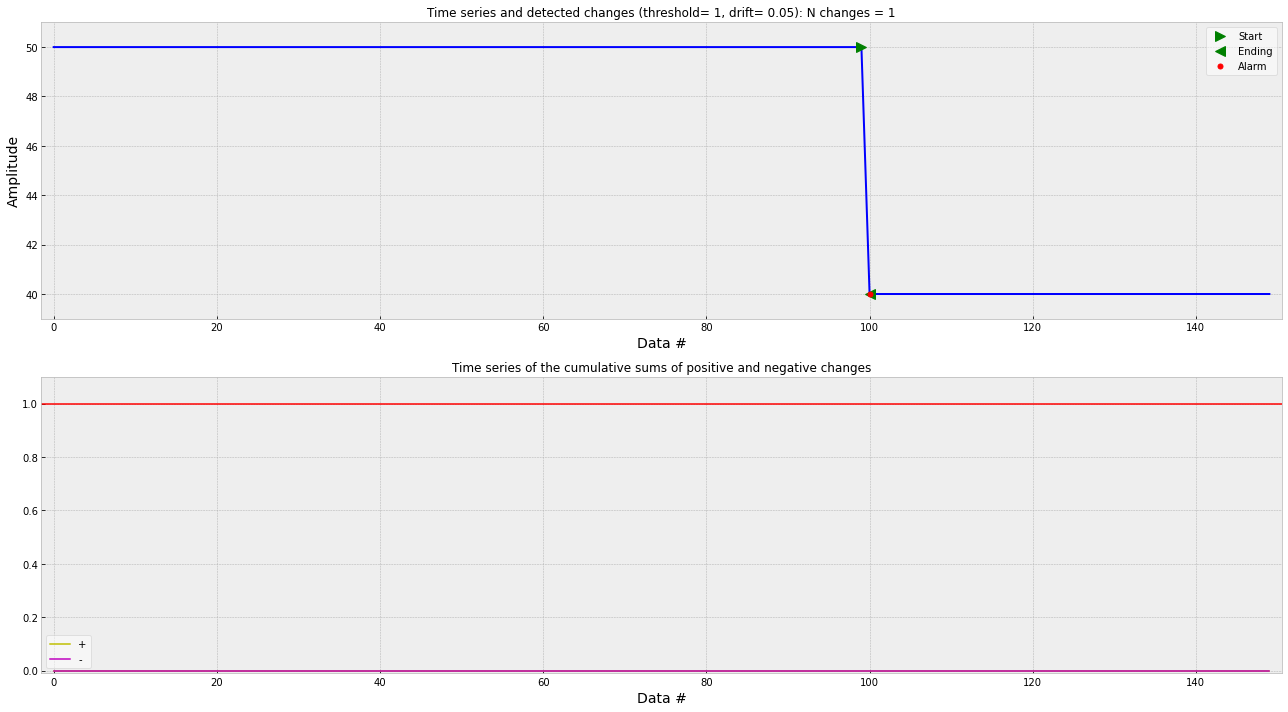

In [160]:
ta, tai, taf, amp = detect_cusum(sig1, 1, .05, True, True)

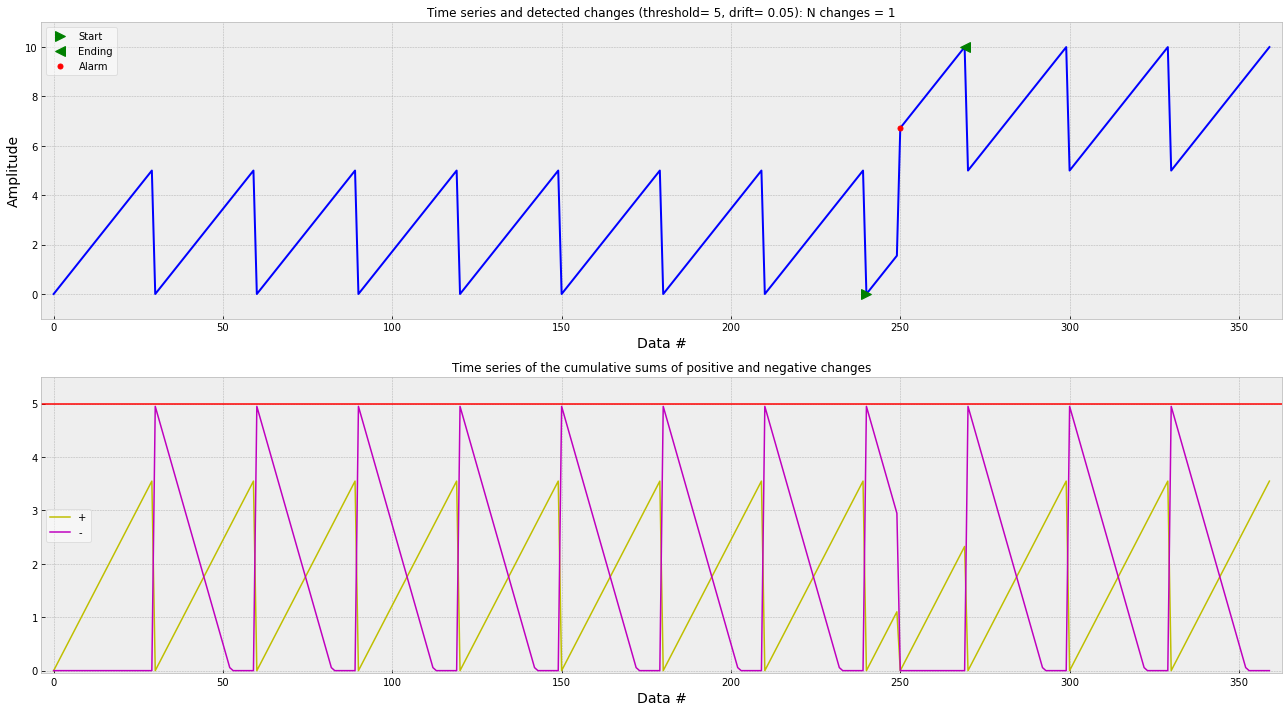

In [161]:
ta, tai, taf, amp = detect_cusum(sig2, 5, .05, True, True)

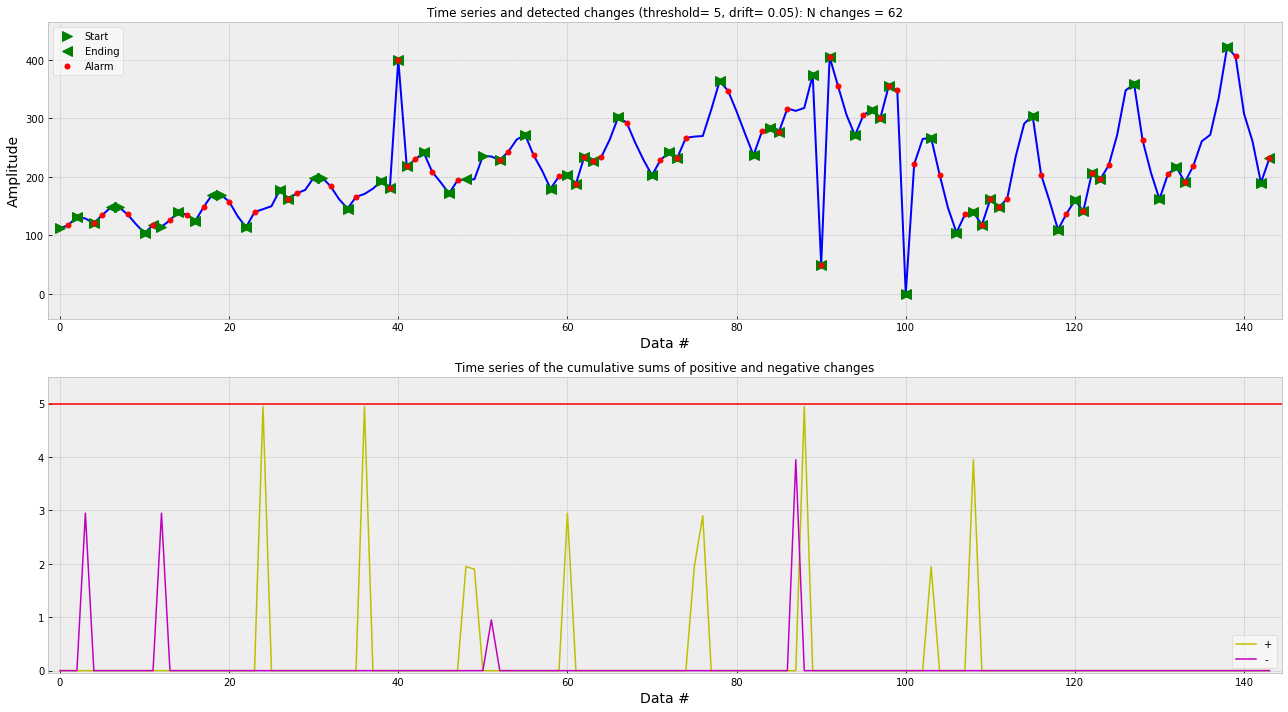

In [295]:
ta, tai, taf, amp = detect_cusum(serias_2, 5, .05, True, True)

## 4. OneClass SVM

На пальцах - пытаемся отделить гипер-плоскостью пространство известных измерений от всего остального

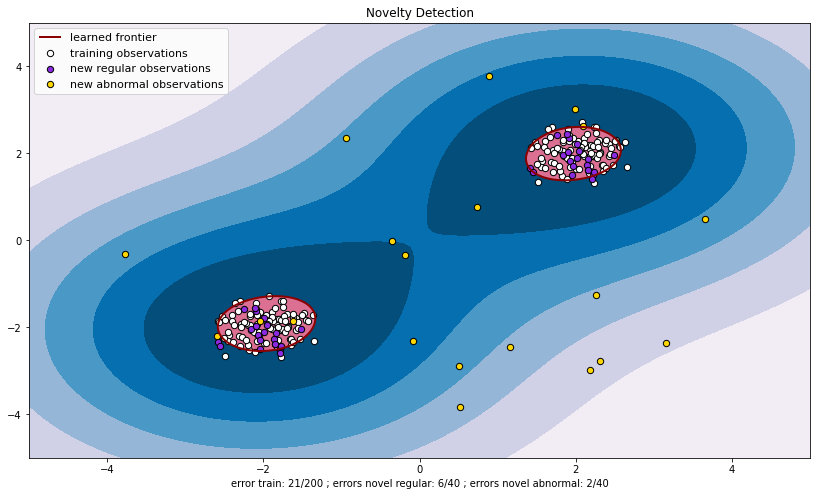

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14,8))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [274]:
serias_3 = pd.read_csv('data/international-airline-passengers.csv')['Count'].values

#исказим сигнал, добавим аномалию
serias_3[100] = 0
serias_3[90] = 50
serias_3[40]  = 400

#добавим шум
noise = np.random.normal(
    size=serias_3.shape,
    scale=0.10)


In [275]:
serias_noise = np.array(serias_3 + noise).reshape(-1, 1)

In [276]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(serias_1_noise[:80])

y_pred_train = clf.predict(serias_1_noise[:80])
y_pred_test = clf.predict(serias_1_noise[80:])

In [277]:
#образуем линейное пространство, чтобы это визализировать

y = np.linspace(-100, 650, 600).reshape(-1, 1)
Z = clf.decision_function(y)
Z = np.hstack((Z, Z))
y = y.reshape(600)

In [278]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, serias_1_noise[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, serias_1_noise[idx]))

In [279]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

<ipython-input-279-6d23dc9b578e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_train = np.array(false_positive_train)
<ipython-input-279-6d23dc9b578e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_test = np.array(false_positive_test)


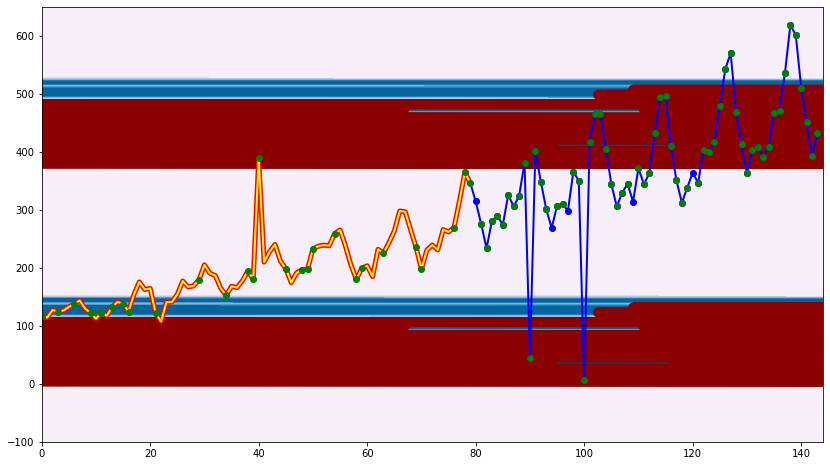

In [280]:
plt.figure(figsize=(14,8))
plt.contourf([0, serias_1_noise.shape[0]], y, Z.reshape(600, 2), cmap=plt.cm.PuBu)
plt.contour([0, serias_1_noise.shape[0]], y, Z.reshape(600, 2), levels=[0], linewidths=10, colors='darkred')
plt.plot(range(80), serias_1_noise[:80], 'red', linewidth=5)
plt.plot(range(80), serias_1_noise[:80], 'yellow', linewidth=2)
plt.plot(range(80,serias_1_noise.shape[0]),serias_1_noise[80:], 'bo', linewidth=10)
plt.plot(range(79,serias_1_noise.shape[0]), serias_1_noise[79:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

Желтым обозначены исторические данные (на которых обучаем), синим - новые (которые смотрим). То что выходит за белое окно и его пороги - является изменениями 